In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams["figure.dpi"] = 150
import ipywidgets as widgets
from particle import PDGID
import sys
sys.path.append("/home/elizahoward/Muon_Collider_Smart_Pixels/daniel/validationPlots")
from plotUtils import *

In [2]:
sensorAngles = np.arange(-np.pi,np.pi+2*np.pi/8,np.pi/8)

In [3]:
sig = pd.read_csv('/home/elizahoward/Muon_Collider_Smart_Pixels/Data_Files/Data_Set_flp_0/Track_Lists/signal_tracks_extra_info_0.txt', sep=' ')

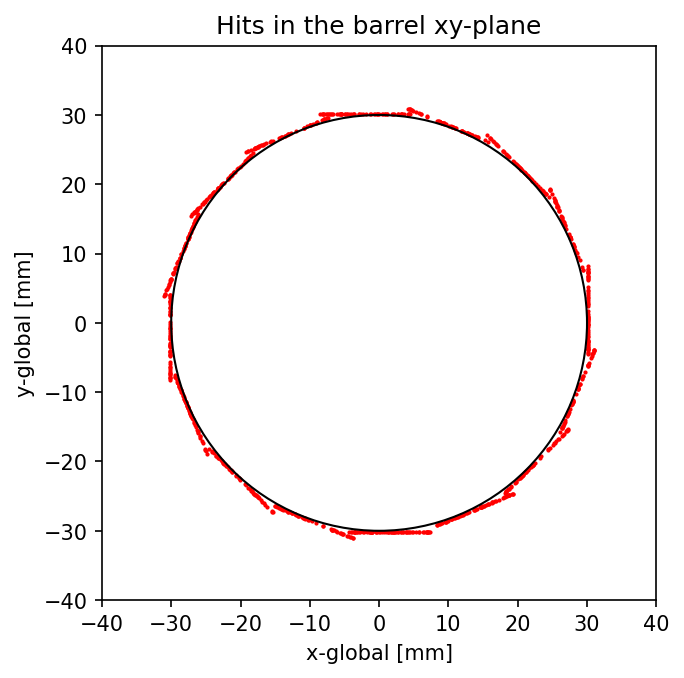

In [4]:
fig,ax=plt.subplots()
ax.scatter(sig['hit_x'],sig["hit_y"],s=1, c='r', label="Signal hits")
plt.gca().set_aspect('equal')
circle=plt.Circle((0,0), 30, fill=0, color='k', label="Barrel")
ax.add_patch(circle)
ax.set_title("Hits in the barrel xy-plane")
ax.set_xlabel("x-global [mm]")
ax.set_ylabel("y-global [mm]")
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
plt.show()

In [39]:
Vec0 = []
Vec1 = []
Vec11 = []
Q=[]
p_from_angles = []

for x, y, phi, theta, cota, cotb, pt, pid, gamma in zip(sig['hit_x'],sig['hit_y'],sig['phi'],sig['theta'],sig['cota'],sig['cotb'],sig['pt'],sig['hit_pdg'],sig['gamma']):

    x0=np.cos(phi)
    y0=np.sin(phi)

    Vec0.append((x0,y0))

    beta = phi-(gamma-np.pi/2)

    if beta < -np.pi:
        beta += 2*np.pi
    if beta > np.pi:
        beta -= 2*np.pi

    xp=np.cos(beta)
    yp=np.sin(beta)
    
    Vec1.append((xp,yp))

    Q.append(PDGID(pid).charge)

    nz=1/np.sqrt(1+cota**2+cotb**2)
    ny=cotb*nz
    nx=cota*nz
    # for alternate vector, scale to magnitude=1
    Vec11.append((ny/np.sqrt(nz**2+ny**2), nz/np.sqrt(nz**2+ny**2)))

    p_from_angles.append(pt / np.sqrt((nz**2 + ny**2)))

sig['vec0'] = Vec0
sig['vec1'] = Vec1
sig['vec11'] = Vec11
sig['Q']=Q
sig['p_from_angles']=p_from_angles

In [52]:

def plot(angleIndex,i,use_weird_tracks=False):
    cut1 = np.abs(sig['gamma'] - sensorAngles[angleIndex])<0.01
    if use_weird_tracks:
        cut2=abs(sig['p']-sig['p_from_angles'])>10
        cut = cut1 & cut2
    else:
        cut = cut1
    # Pull single point and vector
    vec0 = sig['vec0'][cut].reset_index(drop=True)[i]
    vec1 = sig['vec1'][cut].reset_index(drop=True)[i]
    vec11 = sig['vec11'][cut].reset_index(drop=True)[i]
    x0 = sig['hit_x'][cut].reset_index(drop=True)[i]
    y0 = sig['hit_y'][cut].reset_index(drop=True)[i]
    y1 = sig['ylocal'][cut].reset_index(drop=True)[i]

    fig,ax=plt.subplots(ncols=2)
    ax[0].scatter(sig['hit_x'][cut1],sig['hit_y'][cut1],s=1, c='r')
    ax[0].scatter(x0,y0,c='b')
    ax[0].quiver(x0,y0,vec0[0],vec0[1],scale=10)
    ax[0].quiver(0,0,np.cos(sensorAngles[angleIndex]),np.sin(sensorAngles[angleIndex]),scale=10)
    plt.gca().set_aspect('equal')
    circle=plt.Circle((0,0), 30, fill=0, color='k')
    ax[0].add_patch(circle)
    ax[0].set_title("BIB hit location in xy-plane")
    ax[0].set_xlabel("x [mm]")
    ax[0].set_ylabel("y [mm]")
    ax[0].set_xlim(-40,40)
    ax[0].set_ylim(-40,40)
    ax[0].set_aspect('equal')

    ax[1].scatter(y1,0,c='b')
    ax[1].quiver(y1,0,vec1[0],vec1[1],scale=10,color="k")
    ax[1].quiver(y1,0,vec11[0],vec11[1],scale=10,color="b")
    ax[1].hlines(y=0,color='r',xmin=-4.5,xmax=8.5)
    ax[1].set_xlim(-5.5, 9.5) 
    ax[1].set_ylim(-1, 2) 
    ax[1].invert_xaxis()

    ax[1].set_title(f'Total Range: {y1}; ylocal={sig['ylocal'][i]}; Gamma={gamma}')

    plt.show()

In [ ]:
widgets.interact(plot, angleIndex=widgets.IntSlider(min=1, max=16, step=1), i=widgets.IntSlider(min=0, max=100, step=1),use_werid_hits=False)


interactive(children=(IntSlider(value=1, description='angleIndex', max=16, min=1), IntSlider(value=0, descript…

<function __main__.plot(angleIndex, i, use_weird_tracks=False)>

In [27]:
cut=abs(sig['p']-sig['p_from_angles'])>50
len(sig[cut])

255

In [26]:
len(cut)

999

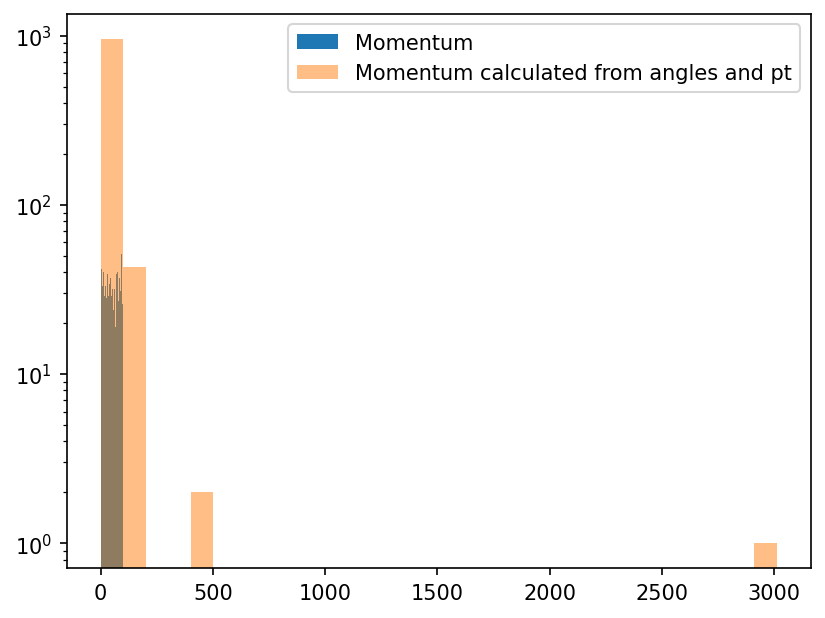

In [27]:
plt.hist(sig['p'],bins=30,label="Momentum")
plt.hist(sig['p_from_angles'],bins=30,label="Momentum calculated from angles and pt",alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

Setting the histogram bins to be the collective range for the input arrs
p max is 99.67663 and min is 1.03387
p from cota and cotb max is 131.47002881022726 and min is 1.0353969217726566
So bins go from 1.03387 to 131.47002881022726, and there are 30 bins with linear spacing


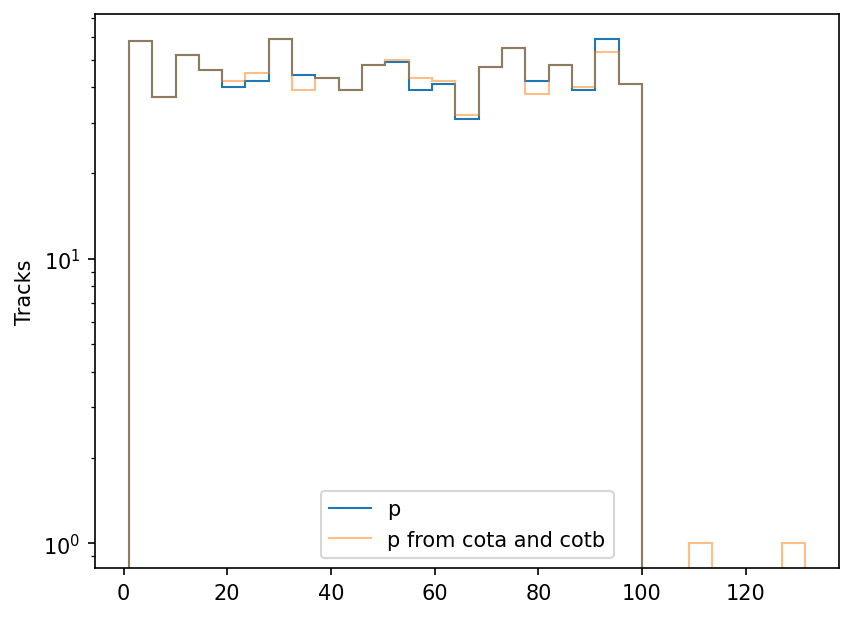

In [40]:
plotManyHisto([sig["p"],sig["p_from_angles"]],pltLabels=["p","p from cota and cotb"],pltStandalone=False,yscale="log",alphas=[1,0.5])


In [50]:
sig[abs(sig['p']-sig['p_from_angles'])>10]

,cota,cotb,p,flp,ylocal,zglobal,pt,t,hit_pdg,hit_x,...,prody,prodz,gamma,phi,theta,vec0,vec1,vec11,Q,p_from_angles
294,0.41041,-0.07988,33.33221,0,-0.625,-39.975,20.41146,0.19820,-13,-27.62627,...,0.00005,0.72099,2.74889,-0.31298,1.18246,"(0.9514202679462148, -0.30789523176098843)","(0.0796382315242257, -0.996823832018323)","(-0.07962636343537544, 0.9968247801123613)",1.0,22.053526
296,0.39799,-0.37343,33.33221,0,-0.600,-38.525,20.41146,0.21413,-13,-27.64223,...,0.00005,0.72099,2.74889,-0.03530,1.21392,"(0.9993770196948247, -0.03529266929391755)","(0.34984219949593026, -0.9368086439886482)","(-0.3498336448819236, 0.9368118385826623)",1.0,21.784020
532,-3.30090,-1.66431,79.97203,0,7.975,18.900,66.65602,0.12510,-13,-18.90755,...,0.00068,-1.86582,1.96350,2.99325,0.53171,"(-0.9890173905985964, 0.14779919178920878)","(-0.8571702576881082, 0.5150331536269313)","(-0.8571714699749087, 0.5150311360112652)",1.0,131.470029
534,3.62696,-2.49680,79.97203,0,-3.425,22.450,66.65602,0.14405,-13,-18.88620,...,0.00068,-1.86582,2.35619,0.40445,0.63808,"(0.9193189684588188, 0.39351319448248917)","(0.9283141944234765, -0.3717966600601622)","(-0.9283124950182081, 0.3718009031633323)",1.0,111.904145
535,0.12794,0.10921,79.97203,0,-3.750,23.950,66.65602,0.15855,-13,-18.66141,...,0.00068,-1.86582,2.35619,2.24741,1.69730,"(-0.6261563084712749, 0.7796975550568473)","(0.1085655930014784, 0.9940892877484584)","(0.10856450410218538, 0.9940894066677537)",1.0,67.192962
737,-0.03785,-0.14326,93.82390,0,-0.425,45.750,53.24897,0.17737,-13,11.92777,...,-0.00002,2.00142,1.17810,1.32039,1.53334,"(0.24779763389916123, 0.9688118148711736)","(-0.14181034140478455, 0.9898938463646789)","(-0.14181215520504845, 0.989893586521349)",1.0,53.286333
738,-0.01969,0.06827,93.82390,0,1.500,45.725,53.24897,0.18771,-13,10.15624,...,-0.00002,2.00142,1.17810,-2.03166,1.59044,"(-0.4447218378243789, -0.8956687372919224)","(-0.06811456548360709, -0.9976775059952887)","(0.06811145781881234, 0.9976777181604269)",1.0,53.259243
739,-0.22773,-0.59290,93.82390,0,-0.300,45.825,53.24897,0.19973,-13,11.82899,...,-0.00002,2.00142,1.17810,1.71328,1.37736,"(-0.14200205465791949, 0.9898663629363962)","(-0.5099958795217042, 0.8601768439518024)","(-0.5099980779624856, 0.8601755405000601)",1.0,54.260988
740,0.50815,0.93455,93.82390,0,1.050,46.300,53.24897,0.20594,-13,10.58401,...,-0.00002,2.00142,1.17810,-2.71507,1.21531,"(-0.9104098553685808, -0.41370749962716397)","(-0.6827920383896215, -0.7306127786397837)","(0.6827931774460466, 0.7306117141362651)",1.0,56.800311
741,-0.25300,0.63107,93.82390,0,0.525,45.575,53.24897,0.21360,-13,11.06165,...,-0.00002,2.00142,1.17810,0.61514,1.36002,"(0.816692664703587, 0.5770728649133958)","(0.5336917423685215, 0.8456790905110826)","(0.5336852780723464, 0.8456831699690152)",1.0,54.454146


In [51]:
sensorAngles

array([-3.14159265, -2.74889357, -2.35619449, -1.96349541, -1.57079633,
       -1.17809725, -0.78539816, -0.39269908,  0.        ,  0.39269908,
        0.78539816,  1.17809725,  1.57079633,  1.96349541,  2.35619449,
        2.74889357,  3.14159265,  3.53429174])